## EfficientNet using Pytorch

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm.notebook import tqdm 

In [61]:
## Configuration
class CFG:
    
    epochs = 1                                         # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset  **also try with 32**
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = '../Sample BCD/images'                  # Data Directory 
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cpu


# Image Transformation and Load Dataset 

In [9]:
from torchvision import transforms as T, datasets
# from helper import show_image
import pydicom
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

In [32]:
# Function to read DICOM file and convert to PIL Image for transformation
def dicom_to_pil(dicom_path):
    dicom = pydicom.dcmread(dicom_path)
    img = dicom.pixel_array  # Get image pixel data as NumPy array
    img = np.stack([img] * 3, axis=-1) # Convert to 3-channel image (H, W, C)
    img = Image.fromarray(np.uint8(img))  # Convert to PIL Image
    return img

In [33]:
train_transform = T.Compose([
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor(), # (h,w,c) -> (c,h,w)
    T.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

val_transform = T.Compose([
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

test_transform = T.Compose([
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

In [20]:
class DICOMDatasetCSV(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.data = df  # Use the DataFrame directly
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_path']  # Use the image path from DataFrame
        label = self.data.iloc[idx]['cancer']  # Replace 'cancer' with your label column name
        image = dicom_to_pil(img_name)

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
# load the dataset
df = pd.read_csv('RSNA_breast_cancer_data.csv')

In [11]:
from sklearn.model_selection import train_test_split

train_df, val_test_df = train_test_split(df, test_size=0.3, stratify=df['cancer'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['cancer'], random_state=42)

In [34]:
train_dataset = DICOMDatasetCSV(df=train_df, img_dir='IMG', transform=train_transform)
val_dataset = DICOMDatasetCSV(df=val_df, img_dir='IMG', transform=val_transform)
test_dataset = DICOMDatasetCSV(df=test_df, img_dir='IMG', transform=test_transform)

In [29]:
print("Trainset Size : {}".format(len(train_dataset)))
print("Validset Size : {}".format(len(val_dataset)))
print("Testset Size : {}".format(len(test_dataset)))

Trainset Size : 1661
Validset Size : 356
Testset Size : 357


# Load Dataset into Batches 

In [16]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid

In [35]:
# Create DataLoaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)

In [18]:
print("No. of batches in trainloader : {}".format(len(train_loader)))
print("No. of Total examples : {}".format(len(train_loader.dataset)))

No. of batches in trainloader : 104
No. of Total examples : 1661


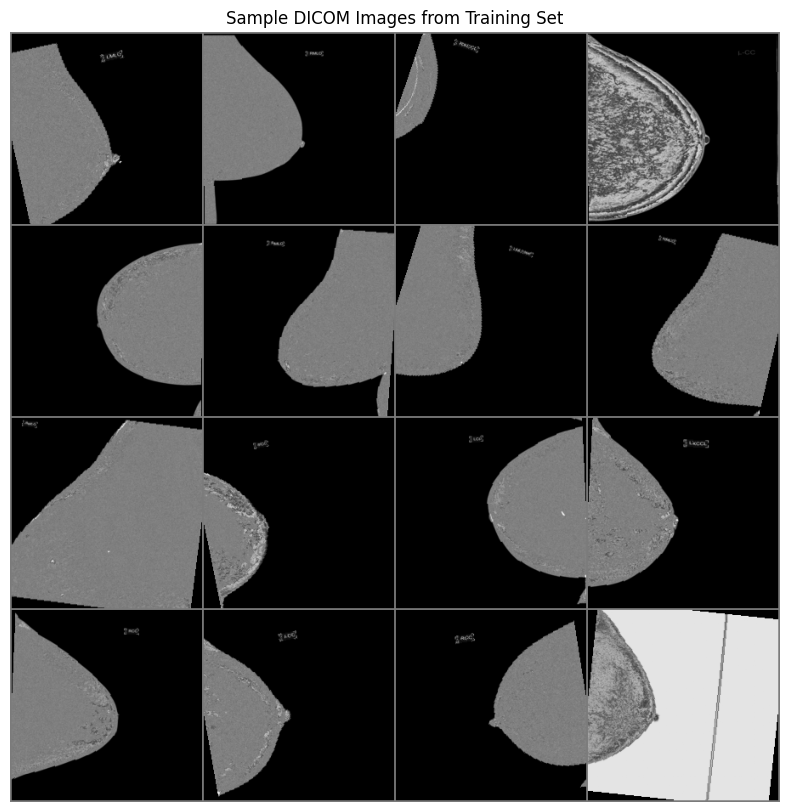

In [36]:
##plot one batch of training data
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# Function to unnormalize and display images
def show_grid(image, title=None):
    image = image.permute(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)
    
    mean = torch.FloatTensor([0.485, 0.485, 0.485])
    std = torch.FloatTensor([0.229, 0.229, 0.229])
    
    image = image * std + mean  # Unnormalize
    image = np.clip(image, 0, 1)  # Clip values to valid range
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')  # Use grayscale colormap
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Make a grid of images
out = torchvision.utils.make_grid(images, nrow=4)

# Show the images
show_grid(out, title="Sample DICOM Images from Training Set")

# Fine Tuning EfficientNet Model 

In [39]:
from torch import nn 
import torch.nn.functional as F
import timm  # pytorch image model

In [74]:
model = timm.create_model(CFG.model_name,pretrained=True)
# this model is trained on imagenet with 1000 classes. so we need to update the final layer to 2 classes

for param in model.parameters():
    param.requires_grad = False

#fine tuning the model to include the classifier part
model.classifier = nn.Sequential(
    nn.Linear(in_features = 1792, out_features = 625),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(in_features=625, out_features = 256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features = 2), # lastlayer 
            #   using cross entropy here instead of biinary cross entropy
            #   so no sigmoid and 2 nodes in final layer to use softmax later
)

In [75]:
from torchsummary import summary 

summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
          Identity-9         [-1, 48, 112, 112]               0
           Conv2d-10             [-1, 12, 1, 1]             588
             SiLU-11             [-1, 12, 1, 1]               0
           Conv2d-12             [-1, 48, 1, 1]             624
          Sigmoid-13             [-1, 48, 1, 1]               0
    SqueezeExcite-14         [-1, 48, 1

# Build a Simple Trainer

In [48]:
# Accuracy function
def accuracy(y_pred, y_true):
    # Convert logits to probabilities using softmax
    y_pred = F.softmax(y_pred, dim=1)
    # Get the predicted class
    top_p, top_class = y_pred.topk(1, dim=1)
    # Compare predicted class with actual label
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [52]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm # displaying progress bars in loops and operations

class BreastCancerTrainer():
    
    def __init__(self, criterion=None, optimizer=None, scheduler=None):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def train_batch_loop(self, model, train_loader):
        train_loss = 0.0
        train_acc = 0.0
        
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Track loss and accuracy
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
        
        return train_loss / len(train_loader), train_acc / len(train_loader)
    
    def valid_batch_loop(self, model, valid_loader):
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            # Track loss and accuracy
            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)
        
        return valid_loss / len(valid_loader), valid_acc / len(valid_loader)
    
    def fit(self, model, train_loader, valid_loader, epochs):
        valid_min_loss = np.inf 
        
        for epoch in range(epochs):
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, train_loader)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, valid_loader)
            
            if avg_valid_loss <= valid_min_loss:
                print("Valid loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
                torch.save(model.state_dict(), 'BreastCancerModelPytorch.pt')  # Save best model
                valid_min_loss = avg_valid_loss
            
            print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.6f} Train Acc: {avg_train_acc:.6f}")
            print(f"Epoch {epoch+1} Valid Loss: {avg_valid_loss:.6f} Valid Acc: {avg_valid_acc:.6f}")

## Training Model

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)  # Adam optimizer with learning rate from CFG
scheduler = None

# Create a custom trainer
trainer = BreastCancerTrainer(criterion, optimizer, scheduler)

# Train the model
trainer.fit(model, train_loader, val_loader, epochs=CFG.epochs)

# Plot Results 

In [ ]:
model.load_state_dict(torch.load('/content/ColabPneumoniaModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,test_loader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

In [ ]:
## to display image with probability
def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [ ]:
import torch.nn.functional as F

image,label = test_dataset[17] # 17 ranndomly chosen image

logit = model(image.to(device).unsqueeze(0)) # squeeze to add batchsise
ps = F.softmax(logit,dim = 1) # probabilities from the logits

view_classify(image,ps,label)